In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import astropy.coordinates
import astropy.units

COMPUTE_SATPOS = '/home/daniel/jupyter_notebooks/galileo-outage/compute_satpos'
COMPUTE_SATPOS_NOFUTUREEPH = '/home/daniel/jupyter_notebooks/galileo-outage/compute_satpos_nofutureeph'

In [2]:
def pos_error(x, svn):
    y = x[svn - 1, :, :, :3]
    return np.sqrt(np.sum((y[:,0,:] - y[:,1,:])**2, axis = 1))

def clk_error(x, svn):
    y = x[svn - 1, :, :, 6]
    return y[:,0] - y[:,1]

def plot_pos_error(x, t, nofuture = False, sel = slice(0,1420)):
    plt.figure(figsize = (12,6), facecolor = 'w')
    legend = False
    for svn in range(1, 37):
        p = pos_error(x, svn)[sel]
        if np.any(p[~np.isnan(p)] > 2):
            legend = True
            plt.semilogy(t[sel], p, label = f'E{svn:02d}')
        else:
            plt.semilogy(t[sel], p)
    if legend:
        plt.legend()
    futurestr = 'not using future ephemerides' if nofuture else 'using future ephemerides'
    plt.title(f'Orbit error ({futurestr})')
    plt.xlabel('GST time')
    plt.ylabel('Error (m)')
    plt.grid()
    
def plot_clk_error(x, t, nofuture = False, sel = slice(0,1420)):
    plt.figure(figsize = (12,6), facecolor = 'w')
    legend = False
    for svn in range(1,37):
        ce = clk_error(x, svn)[sel]
        if np.any(np.abs(ce[~np.isnan(ce)]) > 2.5e-9):
            legend = True
            plt.plot(t[sel], ce, label = f'E{svn:02d}')
        else:
            plt.plot(t[sel], ce)
    if legend:
        plt.legend()
    futurestr = 'not using future ephemerides' if nofuture else 'using future ephemerides'
    plt.title(f'Clock error ({futurestr})')
    plt.xlabel('GST time')
    plt.ylabel('Error (s)')
    plt.grid()

def load_data(path, start_timestamp, timestep = 60):
    x = np.fromfile(path, dtype = 'float64').reshape((36, -1, 2, 8))
    t = np.datetime64(start_timestamp) + np.arange(x.shape[1]) * np.timedelta64(timestep, 's')
    return x, t

def crossprod(x,y):
    return np.stack([x[:,1]*y[:,2] - x[:,2]*y[:,1], x[:,2]*y[:,0]-x[:,0]*y[:,2], x[:,0]*y[:,1]-x[:,1]*y[:,0]], axis = 1)

def compute_vnb_error(x, t, svn):
    v_ecef = astropy.coordinates.CartesianDifferential(x[svn-1,:,0,3:6], xyz_axis = 1, unit = astropy.units.m/astropy.units.s)
    residual_ecef = astropy.coordinates.CartesianRepresentation(x[svn-1,:,0,:3]-x[svn-1,:,1,:3],\
                                                                xyz_axis = 1, unit = astropy.units.m)
    r_ecef = astropy.coordinates.CartesianRepresentation(x[svn-1,:,1,:3],\
                                                         xyz_axis = 1, unit = astropy.units.m, differentials = v_ecef)

    obs_time = astropy.time.Time(t + np.timedelta64(19, 's'), format = 'datetime64', scale = 'tai')
    error_eci = np.array(astropy.coordinates.ITRS(residual_ecef, obstime = obs_time).transform_to(astropy.coordinates.GCRS(obstime = obs_time)).cartesian.xyz).transpose()
    r_eci_transform = astropy.coordinates.ITRS(r_ecef, obstime = obs_time).transform_to(astropy.coordinates.GCRS(obstime = obs_time))
    r_eci = np.array(r_eci_transform.cartesian.xyz).T
    v_eci = np.array(r_eci_transform.cartesian.differentials['s'].d_xyz).T
    
    V = v_eci
    V /= np.sqrt(np.sum(V**2, axis = 1)).reshape((-1,1))
    N = crossprod(V,r_eci)
    N /= np.sqrt(np.sum(N**2, axis = 1)).reshape((-1,1))
    B = crossprod(V,N)
    VNB_rot = np.stack((V,N,B), axis = 1)
    error_vnb = np.einsum('ijk,ik->ij', VNB_rot, error_eci)
    return error_vnb

def plot_vnb_error(x, t, svn, nofuture = False):
    error_vnb = compute_vnb_error(x, t, svn)
    plt.figure(figsize = (12,6), facecolor = 'w')
    plt.plot(t, error_vnb)
    plt.legend(['V', 'N', 'B'])
    futurestr = 'not using future ephemerides' if nofuture else 'using future ephemerides'
    plt.title(f'Orbit error E{svn:02d} ({futurestr})')
    plt.xlabel('GST time')
    plt.ylabel('Error (s)')
    plt.grid()
    
def compare_vnb_error(x1, t1, x2, t2, svn):
    error_vnb1 = compute_vnb_error(x1, t1, svn)
    error_vnb2 = compute_vnb_error(x2, t2, svn)
    plt.figure(figsize = (12,6), facecolor = 'w')
    plt.plot(t, error_vnb1)
    plt.gca().set_prop_cycle(None) # Reset colour cycle to plot again in the same colours
    plt.plot(t, error_vnb2, '--')
    plt.legend(['V1', 'N1', 'B1', 'V2', 'N2','B2'])
    plt.title(f'Orbit error E{svn:02d}')
    plt.xlabel('GST time')
    plt.ylabel('Error (s)')
    plt.grid()    

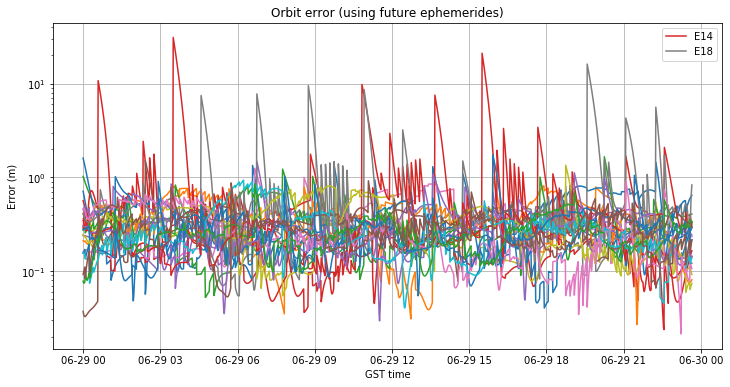

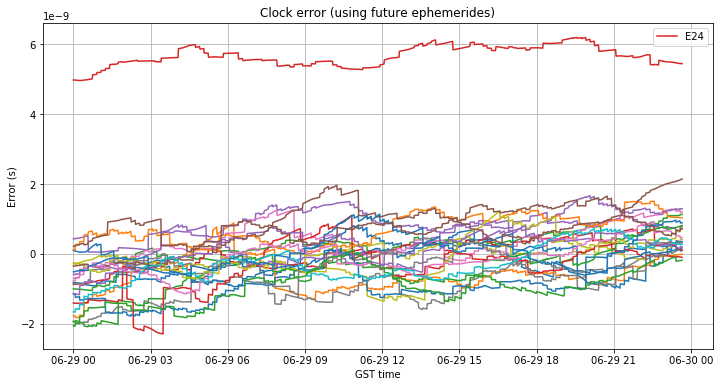

In [3]:
subprocess.call([COMPUTE_SATPOS, 'BRDC00IGS_R_20191800000_01D_MN.rnx.gz',
                 '2019180.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 06 29 00 00 00', '1440', '/tmp/satpos'])
x, t = load_data('/tmp/satpos', '2019-06-29')
plot_pos_error(x, t)
plot_clk_error(x, t)

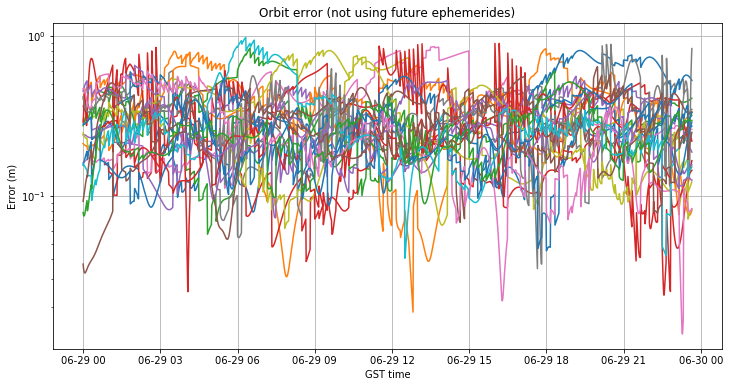

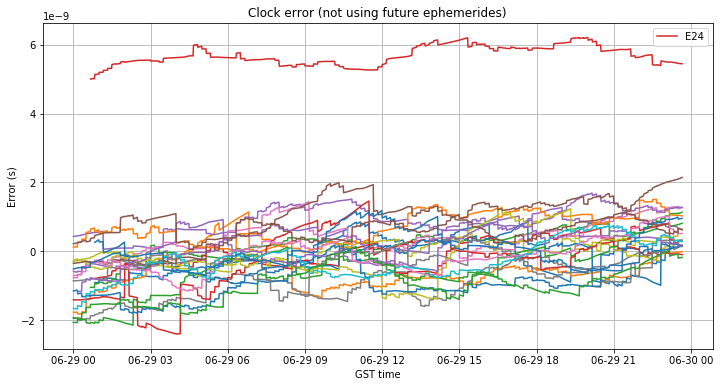

In [4]:
subprocess.call([COMPUTE_SATPOS_NOFUTUREEPH, 'BRDC00IGS_R_20191800000_01D_MN.rnx.gz',
                 '2019180.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 06 29 00 00 00', '1440', '/tmp/satpos'])
xe, te = load_data('/tmp/satpos', '2019-06-29')
plot_pos_error(xe, te, True)
plot_clk_error(xe, te, True)

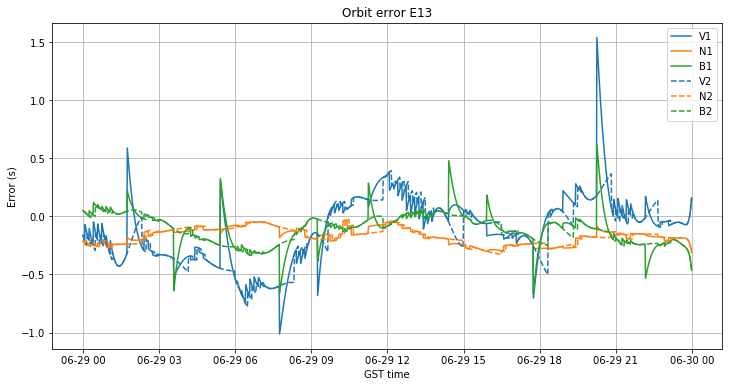

In [5]:
compare_vnb_error(x, t, xe, te, 13)

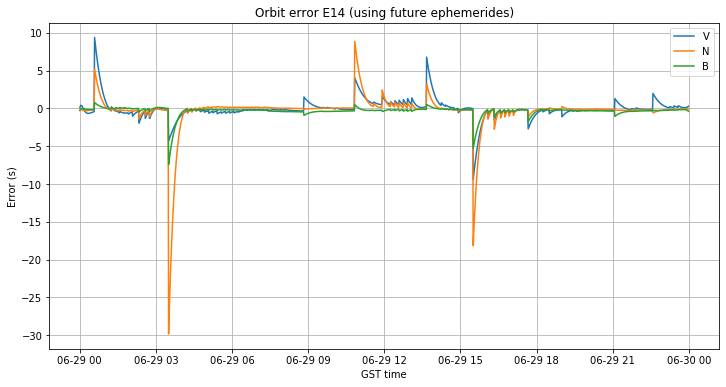

In [6]:
plot_vnb_error(x, t, 14)

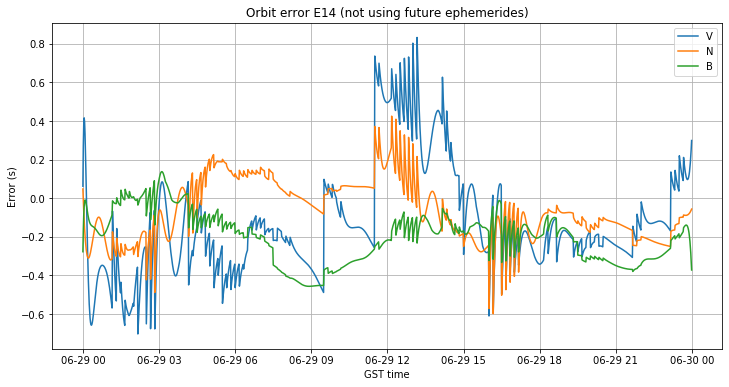

In [7]:
plot_vnb_error(xe, te, 14, True)

/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/_erfa/core.py:4287: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/daniel/.local

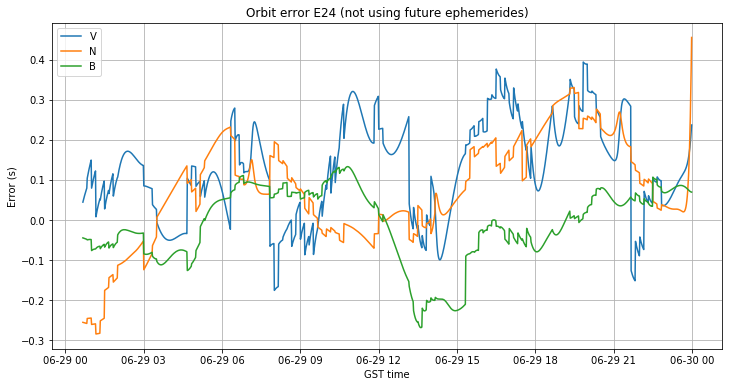

In [8]:
plot_vnb_error(xe, te, 24, True)

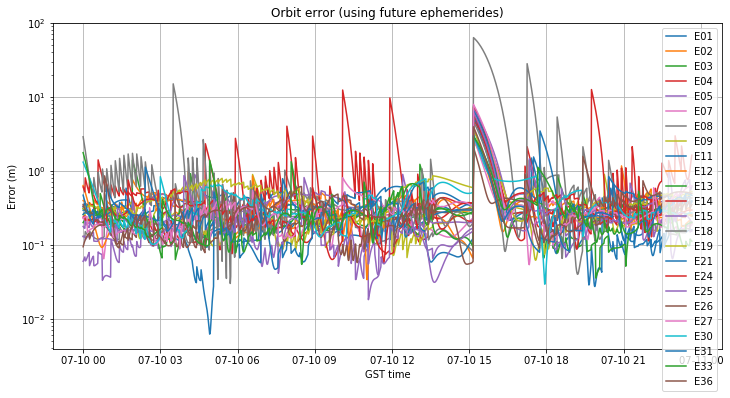

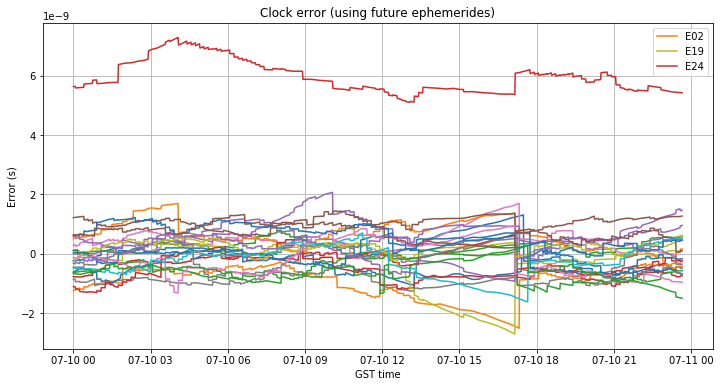

In [9]:
subprocess.call([COMPUTE_SATPOS, 'BRDC00IGS_R_20191910000_01D_MN.rnx.gz',
                 '2019191.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 10 00 00 00', '1440', '/tmp/satpos'])
x, t = load_data('/tmp/satpos', '2019-07-10')
plot_pos_error(x, t)
plot_clk_error(x, t)

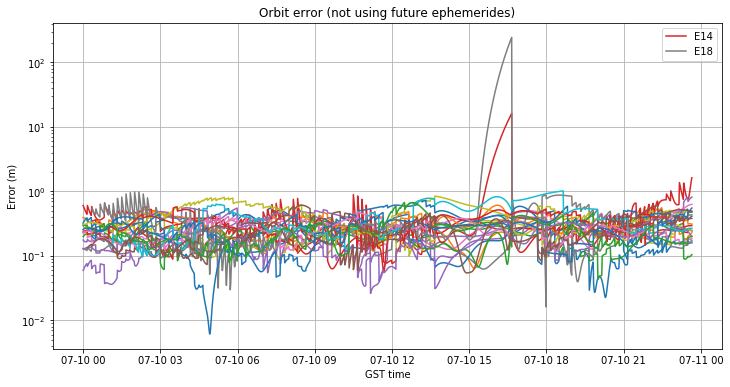

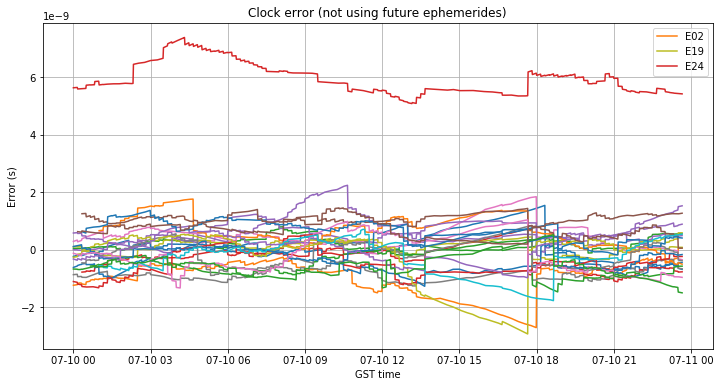

In [10]:
subprocess.call([COMPUTE_SATPOS_NOFUTUREEPH, 'BRDC00IGS_R_20191910000_01D_MN.rnx.gz',
                 '2019191.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 10 00 00 00', '1440', '/tmp/satpos'])
xe, te = load_data('/tmp/satpos', '2019-07-10')
plot_pos_error(xe, te, True)
plot_clk_error(xe, te, True)

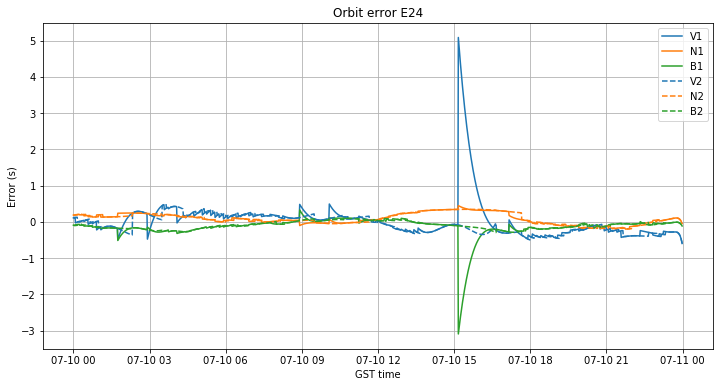

In [11]:
compare_vnb_error(x, t, xe, te, 24)

(-15, 5)

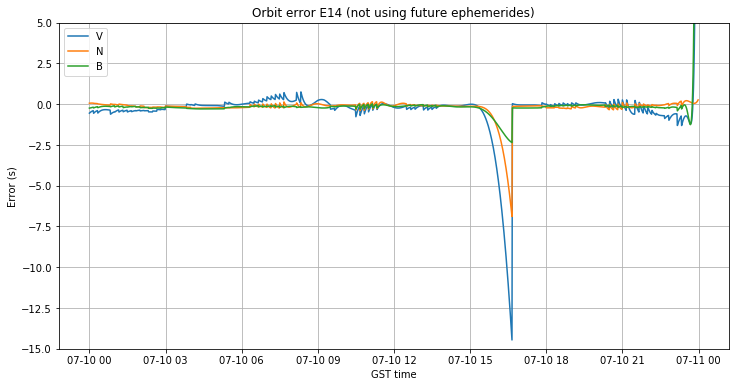

In [12]:
plot_vnb_error(xe, te, 14, True)
plt.ylim((-15,5))

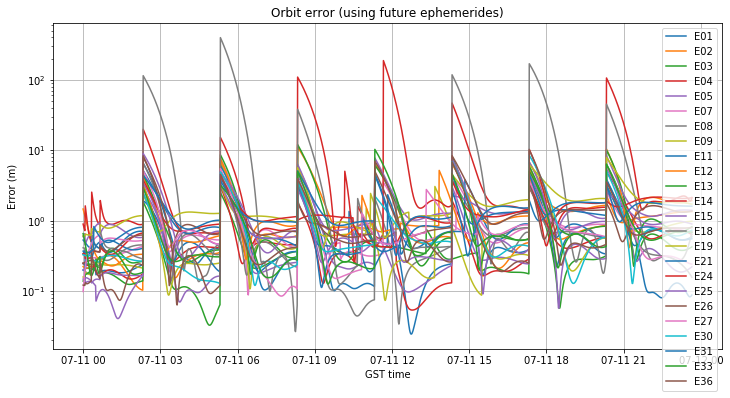

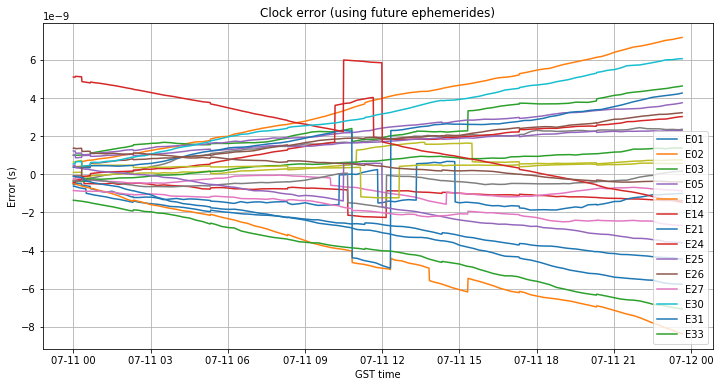

In [13]:
subprocess.call([COMPUTE_SATPOS, 'BRDC00IGS_R_20191920000_01D_MN.rnx.gz',
                 '2019192.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 11 00 00 00', '1440', '/tmp/satpos'])
x, t = load_data('/tmp/satpos', '2019-07-11')
plot_pos_error(x, t)
plot_clk_error(x, t)

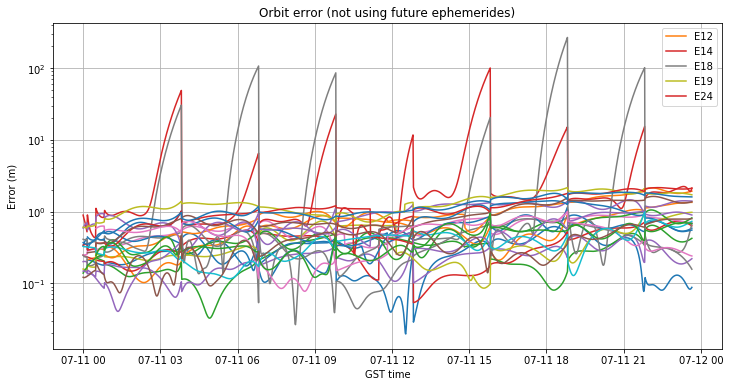

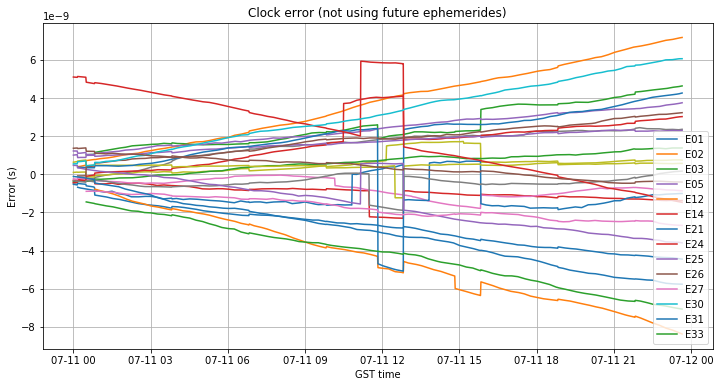

In [14]:
subprocess.call([COMPUTE_SATPOS_NOFUTUREEPH, 'BRDC00IGS_R_20191920000_01D_MN.rnx.gz',
                 '2019192.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 11 00 00 00', '1440', '/tmp/satpos'])
xe, te = load_data('/tmp/satpos', '2019-07-11')
plot_pos_error(xe, te, True)
plot_clk_error(xe, te, True)

/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/_erfa/core.py:4287: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/daniel/.local

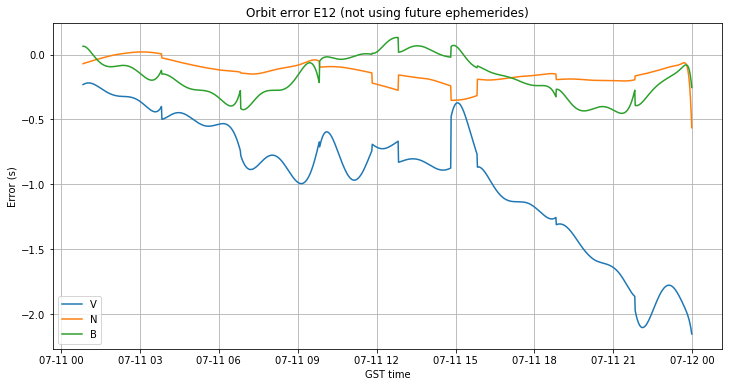

In [15]:
plot_vnb_error(xe, te, 12, True)

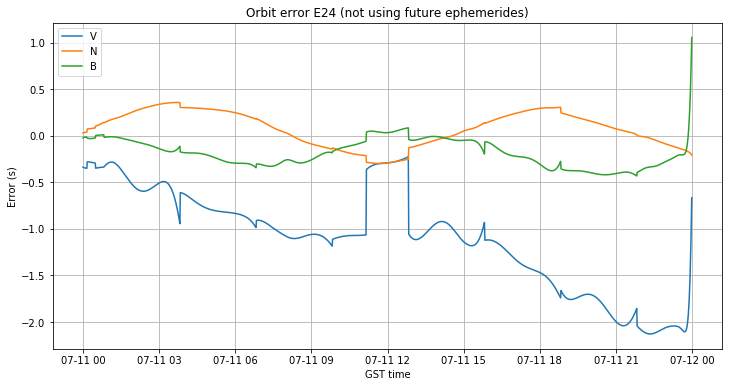

In [16]:
plot_vnb_error(xe, te, 24, True)

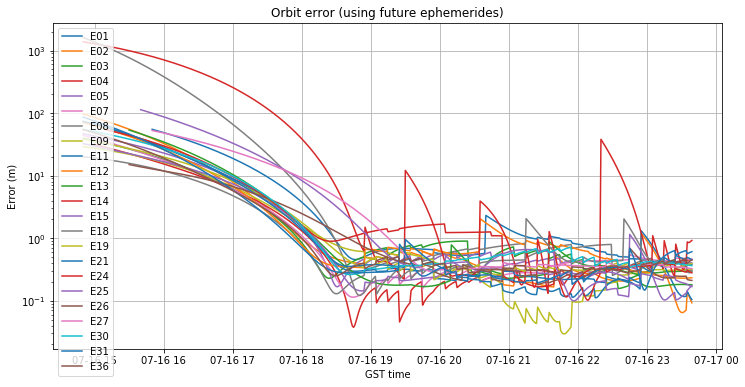

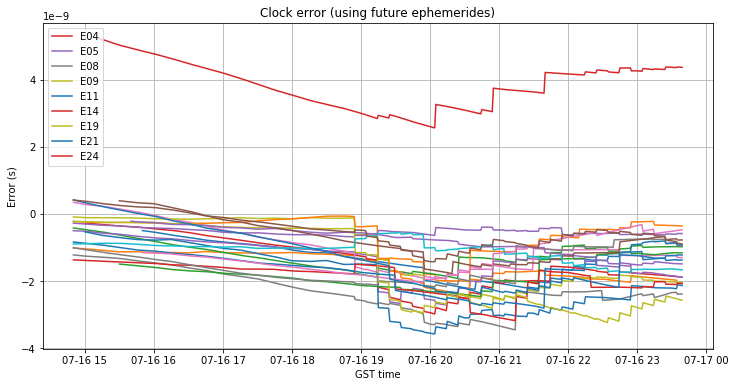

In [17]:
subprocess.call([COMPUTE_SATPOS, 'BRDC00IGS_R_20191970000_01D_MN.rnx.gz',
                 '2019197.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 16 00 00 00', '1440', '/tmp/satpos'])
x, t = load_data('/tmp/satpos', '2019-07-16')
plot_pos_error(x, t)
plot_clk_error(x, t)

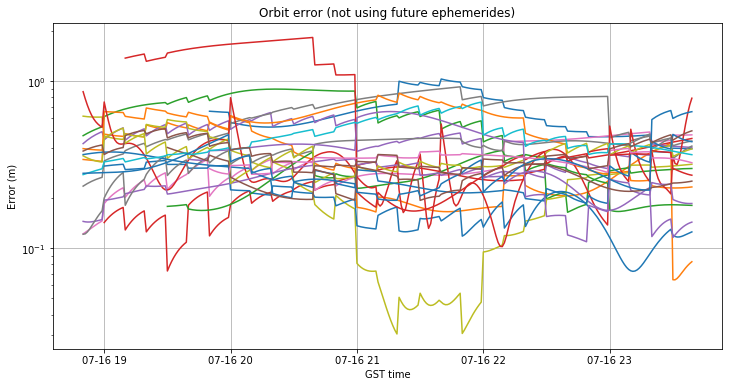

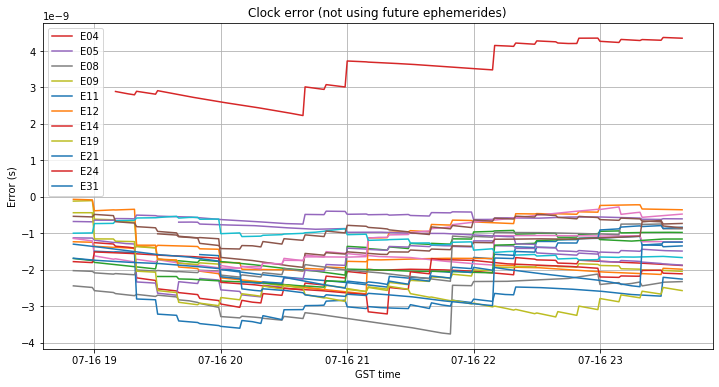

In [18]:
subprocess.call([COMPUTE_SATPOS_NOFUTUREEPH, 'BRDC00IGS_R_20191970000_01D_MN.rnx.gz',
                 '2019197.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 16 00 00 00', '1440', '/tmp/satpos'])
xe, te = load_data('/tmp/satpos', '2019-07-16')
plot_pos_error(xe, te, True)
plot_clk_error(xe, te, True)

/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/_erfa/core.py:4287: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/daniel/.local

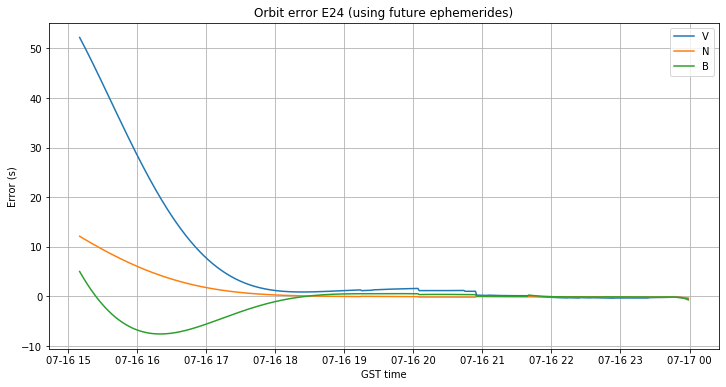

In [19]:
plot_vnb_error(x, t, 24)

/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/home/daniel/.local/lib64/python3.6/site-packages/astropy/_erfa/core.py:4287: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/daniel/.local

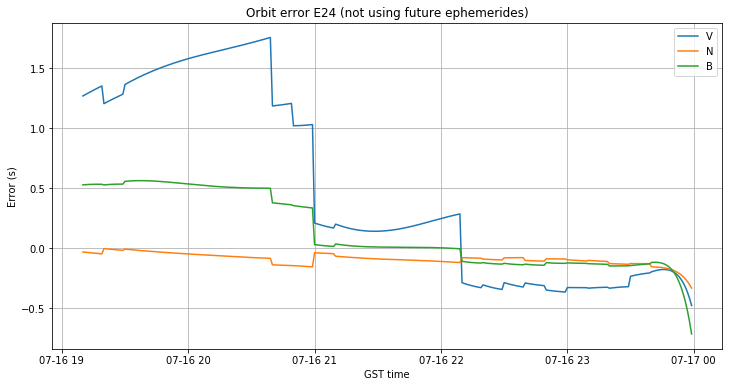

In [20]:
plot_vnb_error(xe, te, 24, True)

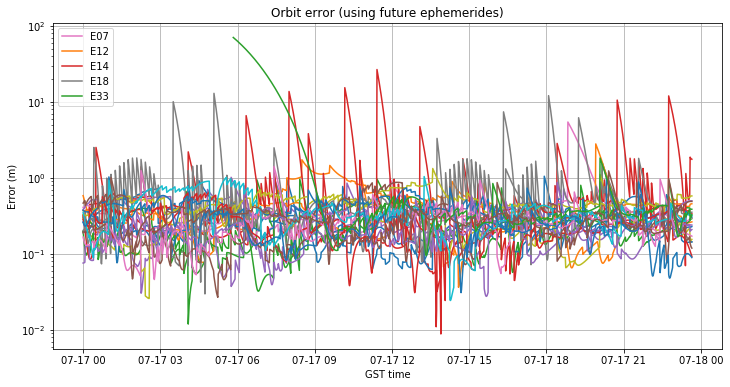

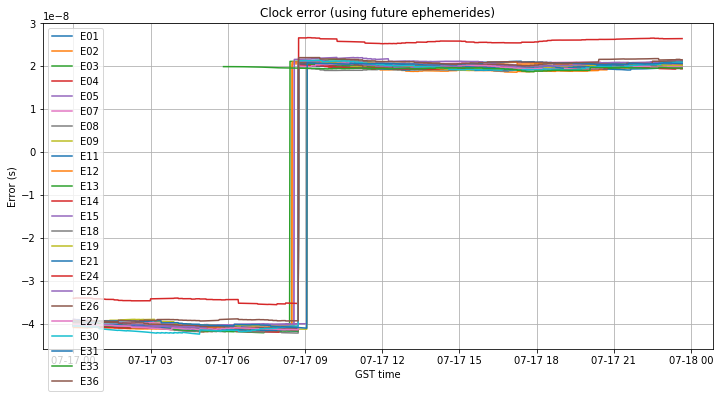

In [21]:
subprocess.call([COMPUTE_SATPOS, 'BRDC00IGS_R_20191980000_01D_MN.rnx.gz',
                 '2019198.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 17 00 00 00', '1440', '/tmp/satpos'])
x, t = load_data('/tmp/satpos', '2019-07-17')
plot_pos_error(x, t)
plot_clk_error(x, t)

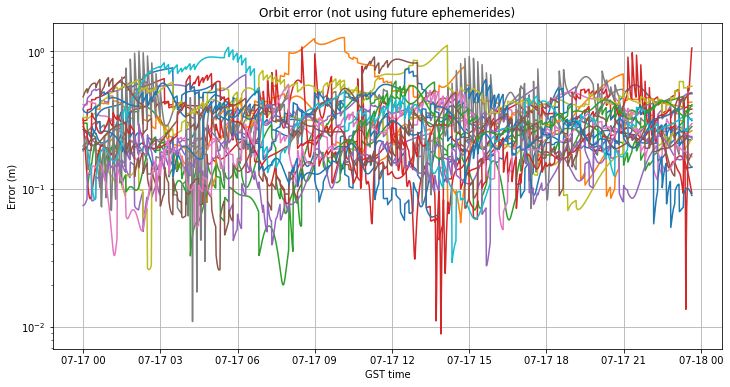

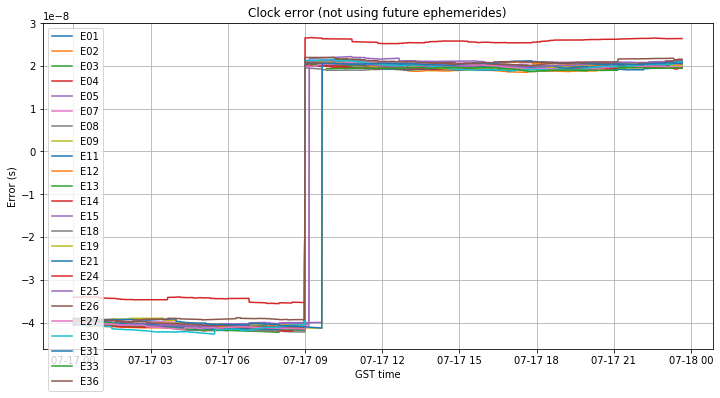

In [22]:
subprocess.call([COMPUTE_SATPOS_NOFUTUREEPH, 'BRDC00IGS_R_20191980000_01D_MN.rnx.gz',
                 '2019198.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 17 00 00 00', '1440', '/tmp/satpos'])
xe, te = load_data('/tmp/satpos', '2019-07-17')
plot_pos_error(xe, te, True)
plot_clk_error(xe, te, True)

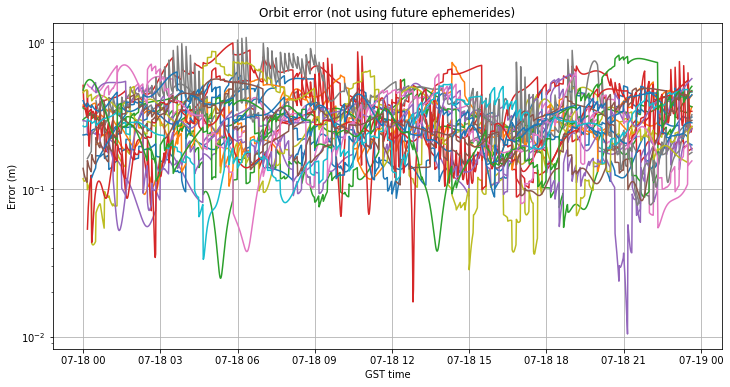

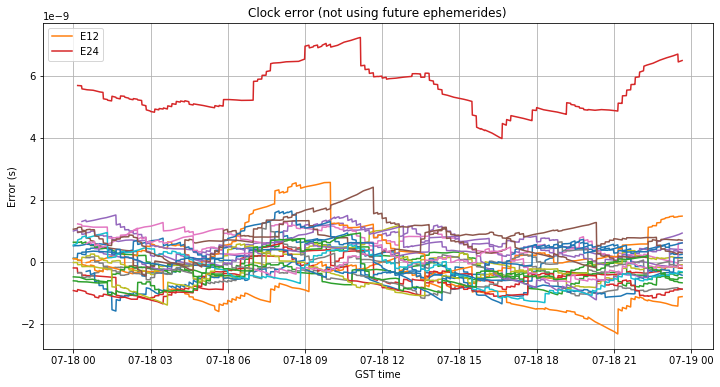

In [23]:
subprocess.call([COMPUTE_SATPOS_NOFUTUREEPH, 'BRDC00IGS_R_20191990000_01D_MN.rnx.gz',
                 '2019199.sp3', 'GSAT_2023_ANTEXRF.atx', '2019 07 18 00 00 00', '1440', '/tmp/satpos'])
xe, te = load_data('/tmp/satpos', '2019-07-18')
plot_pos_error(xe, te, True)
plot_clk_error(xe, te, True)